## Libraries

In [1]:
# base
import pandas as pd
import numpy as np
import sqlite3

# spatial
import geopandas as gpd
from libpysal.cg.voronoi  import voronoi, voronoi_frames

# Map
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Plot
import matplotlib.pyplot as plt

## Data

In [2]:
# Connect to database
conn=sqlite3.connect(r'Data\loans_database.db')

In [3]:
df_city = pd.read_sql_query("""SELECT * 
                              FROM loans 
                              WHERE city='LOS ANGELES' 
                                  AND state='CA' 
                              """, conn)

In [4]:
# Check for missing data
df_city.isnull().sum()

address                  0
approval_year            0
approved_amt             0
bank_id                  0
bank_label               0
business_flag            0
charged_off_amt          0
city                     0
days_to_disbursement     0
def_flag                 0
disbursed_amt            0
disbursement_year        0
employee_num             0
franchise_flag           0
guaranteed_amt           0
guaranteed_pct           0
industry_id              0
industry_label           0
jobs_created_num         0
jobs_retained_num        0
loan_term                0
page_application_flag    0
real_estate_flag         0
recession_flag           0
revolting_flag           0
same_state_flag          0
state                    0
urban_id                 0
zip                      0
dtype: int64

## Add coordinates

In [5]:
def get_coordinates(df, address):
    # import
    from time import sleep
    from random import randint
    from geopy.geocoders import Nominatim
    
    # Function to get data
    def geocode_worker(geolocator, location_dict, address, address_row): 
    # get data
        location = geolocator.geocode(address_row)
        if location:
            location_dict[address].append(address_row)
            location_dict["lat"].append(location.latitude)
            location_dict["lon"].append(location.longitude)
        else:
            location_dict[address].append(address_row)
            location_dict["lat"].append(None)
            location_dict["lon"].append(None)
        return location_dict
        
    # dict
    location_dict = {address:[],
                     "lat":[],
                     "lon":[]}
    
    # connection
    user_agent = 'user_me_{}'.format(randint(10000,99999))
    geolocator = Nominatim(user_agent=user_agent)
        
    # get coordinates
    for address_row in df[address].unique():
        # function
        location_dict = geocode_worker(geolocator, location_dict, address, address_row)

    # merge
    df_geo = pd.DataFrame(location_dict)
    df = df.merge(df_geo, on=address)
    
    return df

In [6]:
df = get_coordinates(df_city, address="address")
df = df.dropna(subset=['lat', 'lon'])

## Map

In [7]:
def plot_city(df, lat, lon, size, alpha, padding):

    # libraries
    import cartopy.crs as ccrs
    import cartopy.io.img_tiles as cimgt
    from urllib.request import urlopen, Request
    import io
    from PIL import Image

    # get border coordinates
    lon_min = df['lon'].min()-padding
    lon_max = df['lon'].max()+padding
    lat_min = df['lat'].min()-padding
    lat_max = df['lat'].max()+padding

    # Connection to street map
    def image_spoof(self, tile): 
        url = self._image_url(tile) 
        req = Request(url) 
        req.add_header('User-agent','Anaconda 3') 
        fh = urlopen(req) 
        im_data = io.BytesIO(fh.read()) 
        fh.close()
        img = Image.open(im_data)
        img = img.convert(self.desired_tile_form) 
        return img, self.tileextent(tile), 'lower'
    cimgt.OSM.get_image = image_spoof 
    osm_img = cimgt.OSM()

    # base plot
    fig = plt.figure(figsize = (10, 10))
    ax = plt.axes(projection=osm_img.crs)

    # street plot 
    extent = [lon_min, lon_max, lat_min, lat_max]
    ax.set_extent(extent)
    ax.add_image(osm_img, 8) 

    # locations
    ax.scatter(df['lon'], df['lat'], color = 'red', s=size, alpha=0.4, transform=ccrs.PlateCarree())

    # show the plot
    plt.show() 

C:\Users\qn74bk\Python\Anaconda3\lib\site-packages\cartopy\mpl\geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


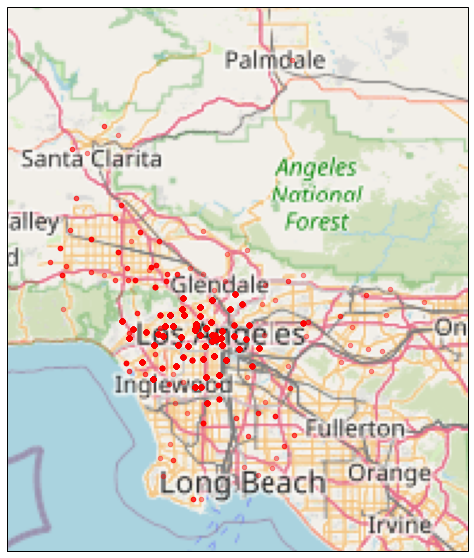

In [8]:
plot_city(df, lat="lat", lon="lon", size=20, alpha=5, padding=0.1)

## Adding jitter to the data

In [9]:
def dist_of_1_degree(df, lat, lon):
    import geopy.distance

    # Get average values for geo location
    avg_lat = df["lat"].mean()
    avg_lon = df["lon"].mean()

    # latitude
    lat = geopy.distance.geodesic((avg_lat, avg_lon), (avg_lat+1, avg_lon)).km
    print("1 degree latitude is equal to: ", lat)

    # Longitude
    lon = geopy.distance.geodesic((avg_lat, avg_lon), (avg_lat, avg_lon+1)).km
    print("1 degree Longitude is equal to: ", lon)
    return lat, lon

def add_jitter(df, lat, lon, max_radius_km):
    # Get avg distances
    lat_1_deg, lon_1_deg = dist_of_1_degree(df, lat, lon)
    
    # Max degree values
    max_lat = max_radius_km/lat_1_deg
    max_lon = max_radius_km/lon_1_deg
    
    # Add jitter
    import random
    random.seed(123)
    df[lat] = df[lat].apply(lambda x: x+random.uniform(-max_lat, max_lat) )
    df[lon] = df[lon].apply(lambda x: x+random.uniform(-max_lon, max_lon) )
    
    return df

In [10]:
df_new = add_jitter(df, lat='lat', lon='lon', max_radius_km = 2)

1 degree latitude is equal to:  110.93230863271717
1 degree Longitude is equal to:  92.3338653688152


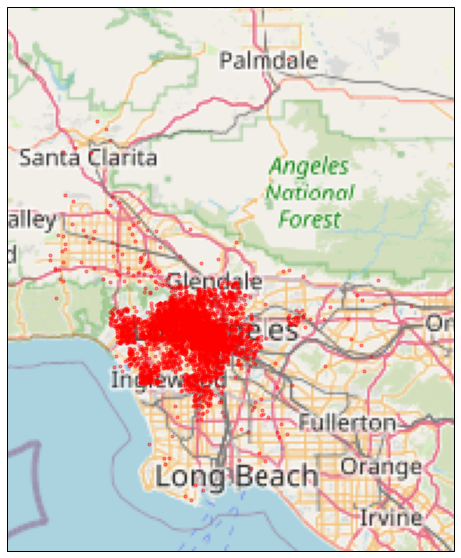

In [11]:
plot_city(df_new, lat="lat", lon="lon", size=10, alpha=0.25, padding=0.1)

## Create geopandas object

In [12]:
def get_geopandas(df, lat, lon):
    
    # get coordinates for each location
    geometry = np.array([[x,y] for x,y in zip(df.lon, df.lat)])
    
    # Generate centroids and shapes
    regions_df, points_df = voronoi_frames(geometry)
    
    # Rename
    regions_df = regions_df.reset_index().rename(columns={"index": "id"})
    points_df = points_df.reset_index().rename(columns={"index": "id"})
    df = df.reset_index().rename(columns={"index": "id"})    
        
    # Merge 
    results_shape = gpd.GeoDataFrame(regions_df.merge(df, on='id').drop(columns='id'))    
    results_points = gpd.GeoDataFrame(points_df.merge(df, on='id').drop(columns='id'))   
    return results_shape, results_points

In [13]:
df_shapes, df_points = get_geopandas(df_new, lat='lat', lon='lon')
df_shapes.head()

,geometry,address,approval_year,approved_amt,bank_id,bank_label,business_flag,charged_off_amt,city,days_to_disbursement,...,page_application_flag,real_estate_flag,recession_flag,revolting_flag,same_state_flag,state,urban_id,zip,lat,lon
0,"POLYGON ((-118.28325 33.93536, -118.28289 33.9...","90047, LOS ANGELES, CA, USA",2006,35000.0,4708,WELLS FARGO BANK NATL ASSOC,1,34343.0,LOS ANGELES,52,...,0,0,1,1,0,CA,1,90047,33.934802,-118.283959
1,"POLYGON ((-118.28305 33.93640, -118.28324 33.9...","90047, LOS ANGELES, CA, USA",2006,30000.0,2618,JPMORGAN CHASE BANK NATL ASSOC,1,0.0,LOS ANGELES,74,...,0,0,1,1,0,CA,2,90047,33.936057,-118.281789
2,"POLYGON ((-118.31072 33.94833, -118.31031 33.9...","90047, LOS ANGELES, CA, USA",1997,900000.0,370,BANCO POPULAR NORTH AMERICA,0,0.0,LOS ANGELES,27,...,0,1,1,0,1,CA,0,90047,33.947598,-118.313686
3,"POLYGON ((-118.29439 33.93972, -118.28989 33.9...","90047, LOS ANGELES, CA, USA",2005,50000.0,398,BANK OF AMERICA NATL ASSOC,0,26704.0,LOS ANGELES,19,...,0,0,0,1,0,CA,1,90047,33.936797,-118.291166
4,"POLYGON ((-118.28209 33.96719, -118.28092 33.9...","90047, LOS ANGELES, CA, USA",2005,100000.0,398,BANK OF AMERICA NATL ASSOC,0,84554.0,LOS ANGELES,19,...,0,0,1,0,0,CA,1,90047,33.965409,-118.284368


In [14]:
df_points.head()

,geometry,address,approval_year,approved_amt,bank_id,bank_label,business_flag,charged_off_amt,city,days_to_disbursement,...,page_application_flag,real_estate_flag,recession_flag,revolting_flag,same_state_flag,state,urban_id,zip,lat,lon
0,POINT (-118.28396 33.93480),"90047, LOS ANGELES, CA, USA",2006,35000.0,4708,WELLS FARGO BANK NATL ASSOC,1,34343.0,LOS ANGELES,52,...,0,0,1,1,0,CA,1,90047,33.934802,-118.283959
1,POINT (-118.28179 33.93606),"90047, LOS ANGELES, CA, USA",2006,30000.0,2618,JPMORGAN CHASE BANK NATL ASSOC,1,0.0,LOS ANGELES,74,...,0,0,1,1,0,CA,2,90047,33.936057,-118.281789
2,POINT (-118.31369 33.94760),"90047, LOS ANGELES, CA, USA",1997,900000.0,370,BANCO POPULAR NORTH AMERICA,0,0.0,LOS ANGELES,27,...,0,1,1,0,1,CA,0,90047,33.947598,-118.313686
3,POINT (-118.29117 33.93680),"90047, LOS ANGELES, CA, USA",2005,50000.0,398,BANK OF AMERICA NATL ASSOC,0,26704.0,LOS ANGELES,19,...,0,0,0,1,0,CA,1,90047,33.936797,-118.291166
4,POINT (-118.28437 33.96541),"90047, LOS ANGELES, CA, USA",2005,100000.0,398,BANK OF AMERICA NATL ASSOC,0,84554.0,LOS ANGELES,19,...,0,0,1,0,0,CA,1,90047,33.965409,-118.284368


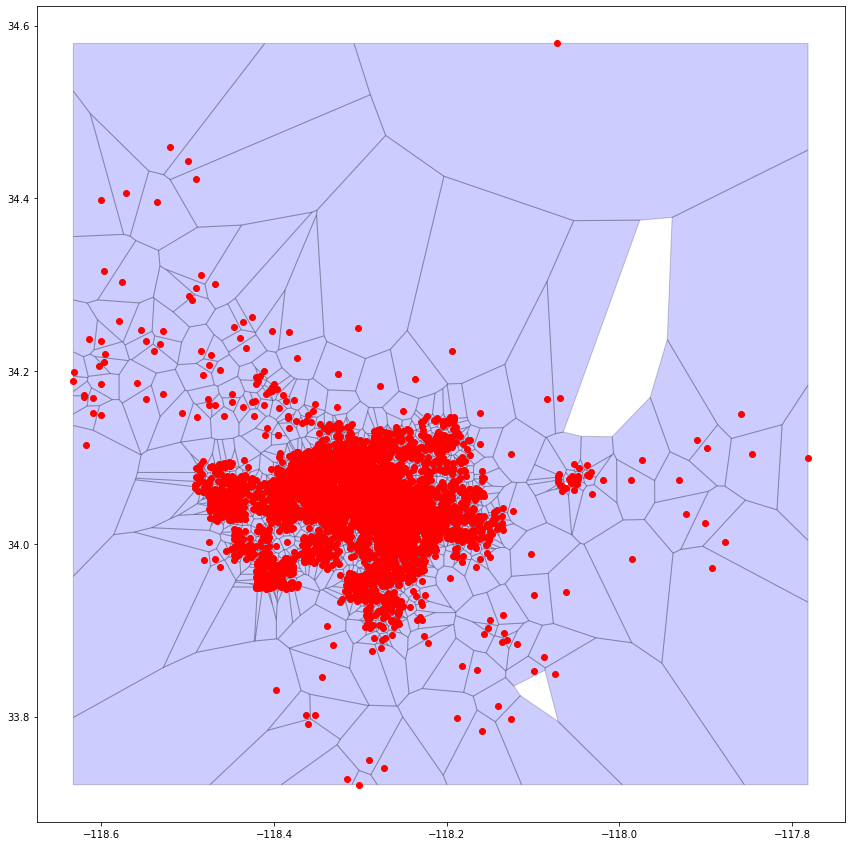

In [15]:
# plot to see if everything is ok
fig, ax = plt.subplots(figsize=(15,15))
df_shapes.geometry.plot(ax=ax, edgecolor='black', facecolor='blue', alpha=0.2 )
df_points.plot(ax=ax, color='red')
plt.show()

## Save geopandas object

In [16]:
df_shapes.to_file("data/loan_geodata.gpkg", layer='shapes', driver="GPKG")
df_points.to_file("data/loan_geodata.gpkg", layer='points', driver="GPKG")